In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# **1: Data Description**

**Summary of Players**

- Rows: 196
- Columns: 9

**Column Descriptions for Players**
- experience
    - chr
    - The self reported experience level of each player
    - Should be represented as a factor. Is also self reported with no clear definitions of each cateogory, making the data unreliable
- subscribe
    - lgl
    - Describes whether or not the player wis subscribed to PlaiCraft
    - Unclear column name creates confusion
- hashedEmail
    - chr
    - Unique encrypted code representing the players email. Encypted to preserve privacy
    - Unreadable at first glance, need to use computation to use or compare values
- played_hours
    - dbl
    - the amount of time each player spent on the server
    - Only records to the first decimal point, creates a lack of specificity as the exact amount of time on the server is not recorder, e.g. to the second or the minute
- name
    - chr
    - first name of the player
    - Self reported with the possibility for typos
- gender
    - chr
    - The self reported gender of each player
    - Some values missing as players preffered not to say. Also, would be better represented as a factor
- age
    - dbl
    - Age of each player in years
    - Would be better represented as an integer. Seems to include some unlikely values (e.g. age 9) that creates uncertainty in data reliability
- individualID
    - lgl
    - indicates whether or not the player has an individual ID
    - Column name is not descriptive, and is NA for all players in this set, making it unusable
- organizationName
    - lgl
    - indicates whether or not the player has an organizational name
    - Column name is not descriptive, and is NA for all players in this set, making it unusable

**Summary of Sessions**
- Rows: 1535
- Columns: 5

**Column Description for Sessions**

- hashedEmail
    - chr
    - Unique encrypted code representing the players email. Encypted to preserve privacy
    - Unreadable at first glance, need to use computation to use or compare values
- start_time
    - chr
    - Start time of the session, including the date, hour, and minute. Converted from the original_start_time column
    - Should be represented as a date type so we can do actual computation with the column
- end_time
    - chr
    - End time of the session, including the date, hour, and minute. Converted from the original_end_time column
    - Should be represented as a date type so we can do actual computation with the column
- original_start_time
    - dbl
    - The exact second the session began
    - Data is not presented in an easily readible format, and must be converted for us to understand
- original_end_time
    - dbl
    - The exact second the session ended
    - Data is not presented in an easily readible format, and must be converted for us to understand

# **2: Question**

**Question:** What players are likely to continue playing given their past participation? Our theory is that players that have played many hours will also have more sessions played, and will therefore continue playing longer. To make our actual prediction, we will use regression analysis to predict the count of sessions by the played_hours. Hopefully, we will find a positive correlation between played_hours and the count of sessions, allowing us to suggest that those with a high amount of played_hours will continue playing longer. 

To complete this regression, we will create a column counting the number of times a player has logged in for a session and also use the played_hours column in players to create a scatteplot. To create this new column showing the count of sessions per player, we will group by the hashedEmail and summarize the count of sessions per email. Next we will wrangle the data to join the played_hours column from the players tibble to the new tibble containing the hashedEmail and count of sessions played, we will do this by matching the hashedEmail using the merge function. 



# **3: Exploratory Data Analysis and Visualization**

In [2]:
players <- read_csv("https://raw.githubusercontent.com/Snowy129/DSCI100-Project/refs/heads/main/players.csv")
head(players)

sessions <- read_csv("https://raw.githubusercontent.com/Snowy129/DSCI100-Project/refs/heads/main/sessions.csv")
head(sessions)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


**Wrangling Data**

In [3]:
sessions_per_player <- sessions|>
    group_by(hashedEmail) |>
    summarize(session_count = n()) |>
    arrange(-session_count)
head(sessions_per_player)

play_time_session_count_merged <- merge(players, sessions_per_player, by = "hashedEmail") |>
    select(hashedEmail, played_hours, session_count)
head(play_time_session_count_merged)

hashedEmail,session_count
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,147
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,130
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,95


,hashedEmail,played_hours,session_count
,<chr>,<dbl>,<int>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1.5,2
2,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,0.4,1
3,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,0.1,1
4,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,5.6,13
5,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,1.0,2
6,11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,0.1,1


**Initial Graphs Used When Deciding my Question**

Warning message:
“Removed 15 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


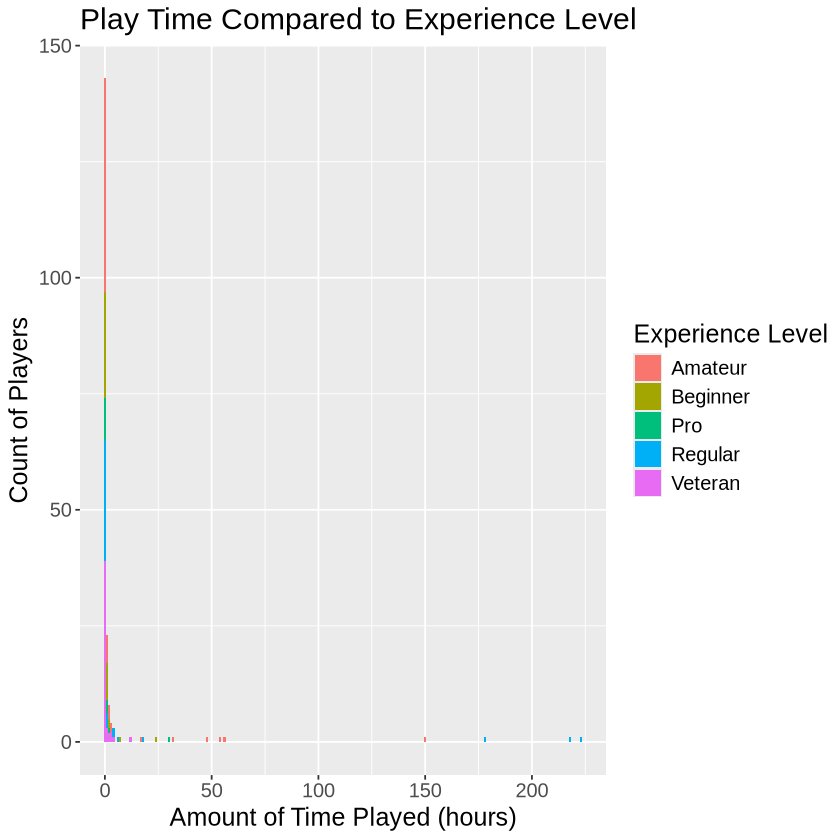

Warning message:
“Removed 13 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


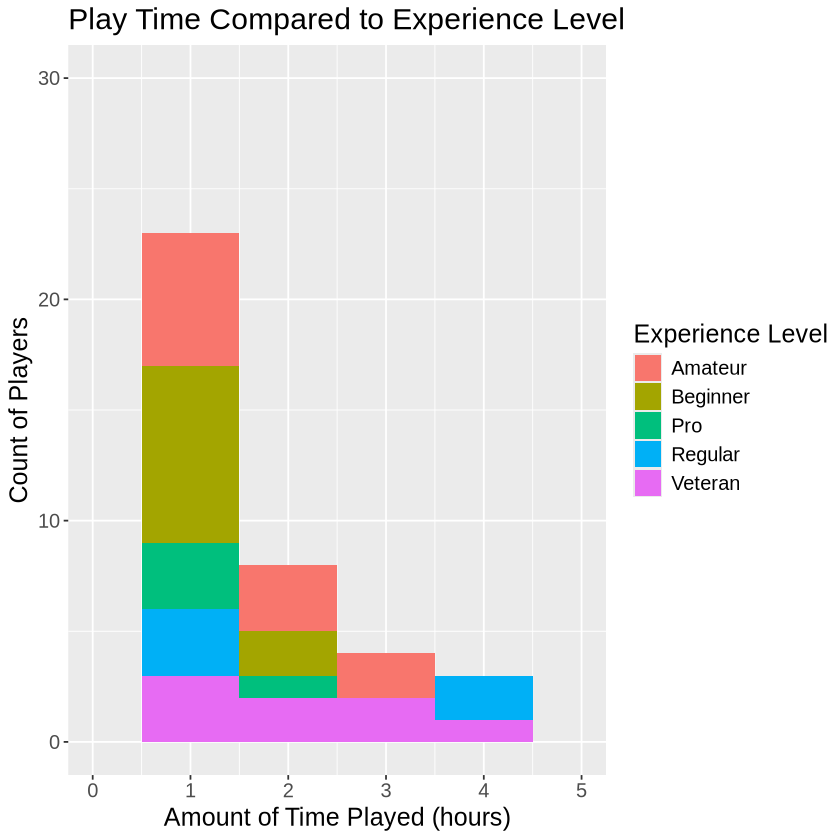

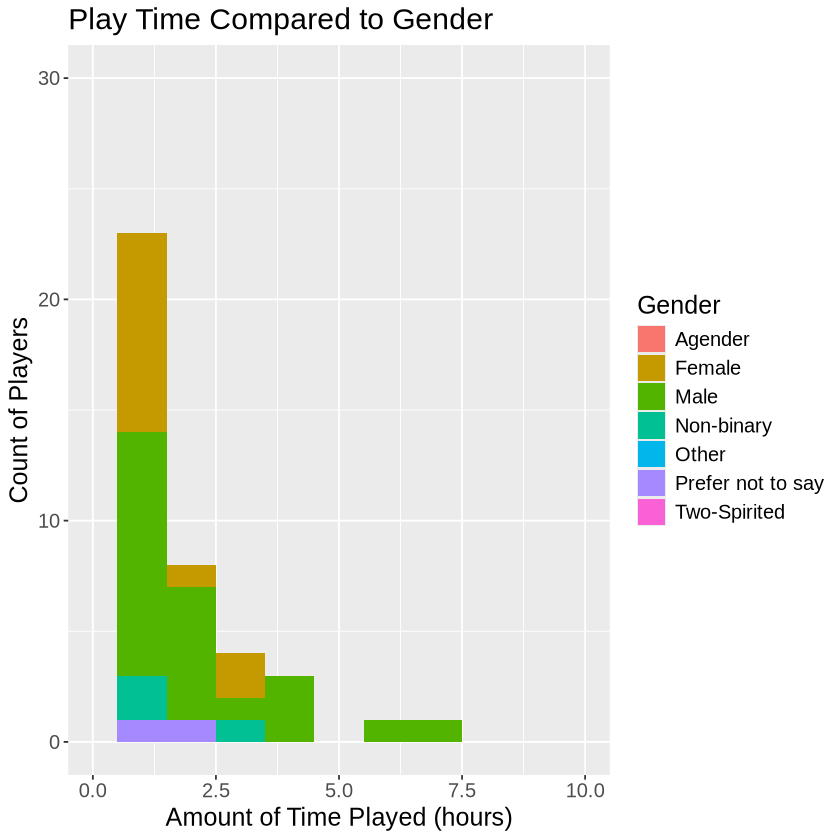

In [4]:
experience_time_played_histogram <- players |>
    ggplot(aes(x = played_hours, fill = experience)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Amount of Time Played (hours)", y = "Count of Players", fill = "Experience Level", title = "Play Time Compared to Experience Level") +
    theme(text = element_text(size = 15))
experience_time_played_histogram 

experience_time_played_histogram_limits <- players |>
    ggplot(aes(x = played_hours, fill = experience)) +
    geom_histogram(binwidth = 1) +
    scale_x_continuous(limits = c(0,5)) +
    scale_y_continuous(limits = c(0, 30)) +
    labs(x = "Amount of Time Played (hours)", y = "Count of Players", fill = "Experience Level", title = "Play Time Compared to Experience Level") +
    theme(text = element_text(size = 15))
experience_time_played_histogram_limits


gender_time_played_histogram <- players |>
    ggplot(aes(x = played_hours, fill = gender)) +
    geom_histogram(binwidth = 1) +
    scale_x_continuous(limits = c(0,10)) +
    scale_y_continuous(limits = c(0, 30)) +
    labs(x = "Amount of Time Played (hours)", y = "Count of Players", fill = "Gender", title = "Play Time Compared to Gender") +
    theme(text = element_text(size = 15))
gender_time_played_histogram 

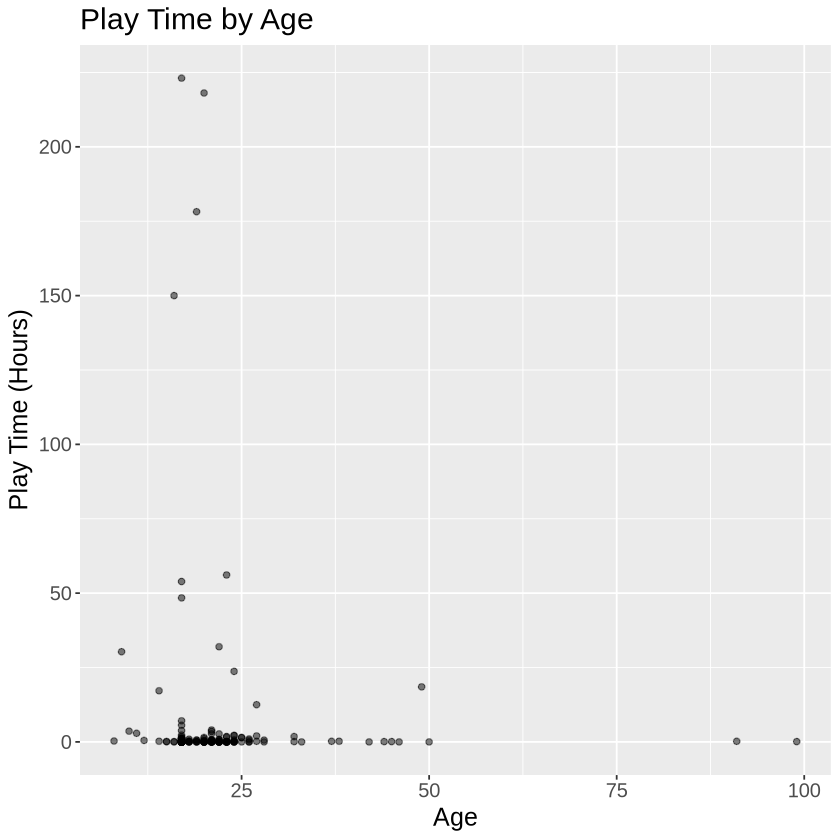

In [5]:
played_time_age_scatteplot <- players |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age", y = "Play Time (Hours)", title = "Play Time by Age") +
    theme(text = element_text(size = 15))

#    scale_x_continuous(limits = c(0,5)) 
played_time_age_scatteplot

**Exploring Time Played and Count of Sessions**

Warning message:
“Removed 21 rows containing missing values or values outside the scale range
(`geom_point()`).”


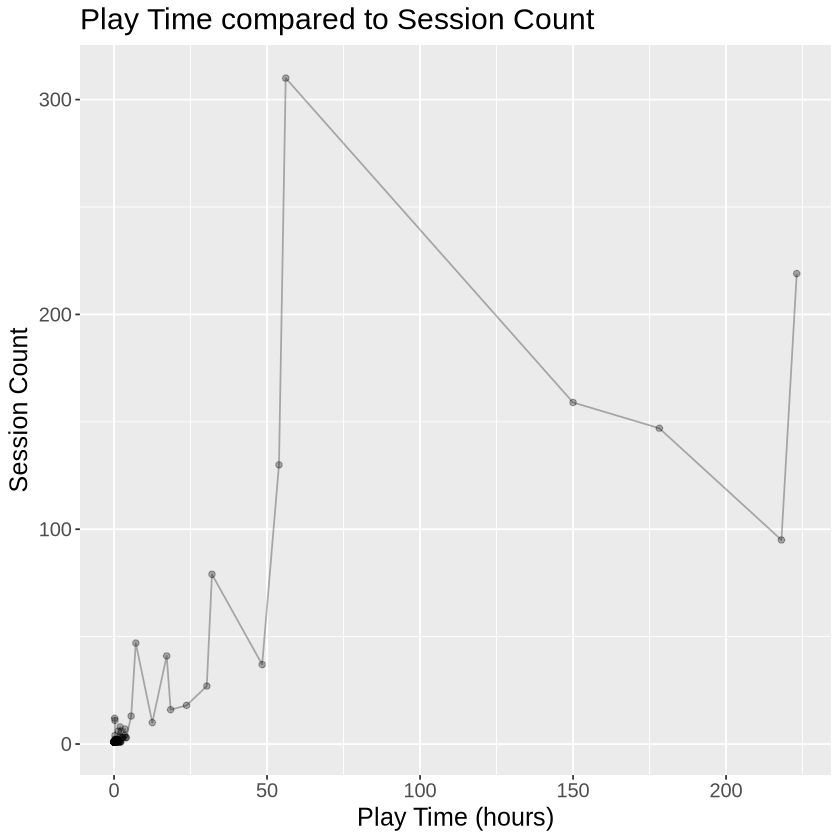

Warning message:
“Removed 31 rows containing missing values or values outside the scale range
(`geom_point()`).”


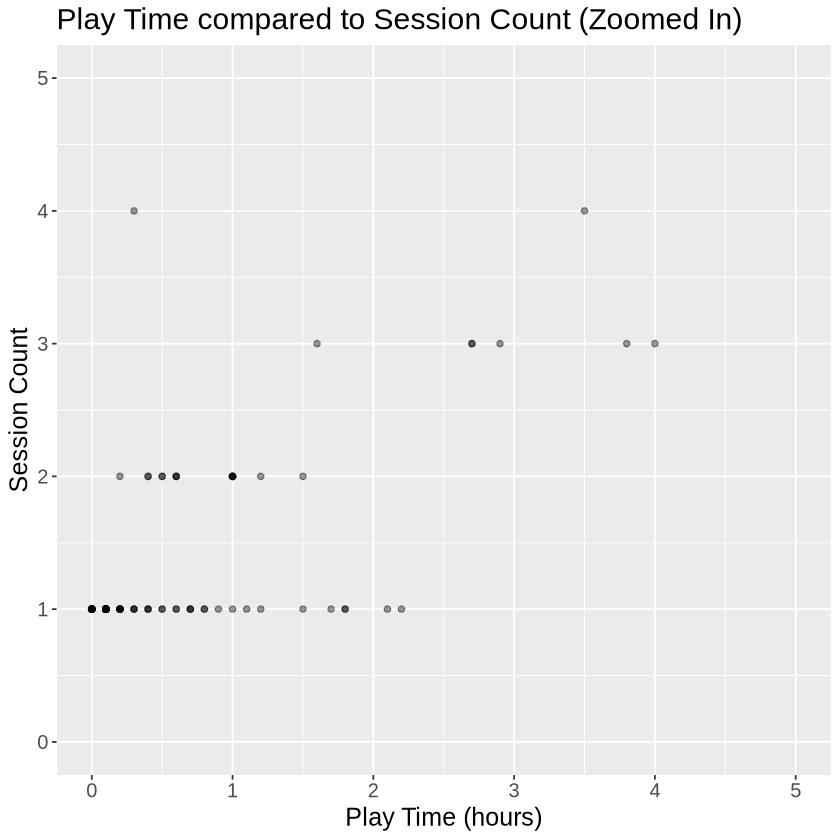

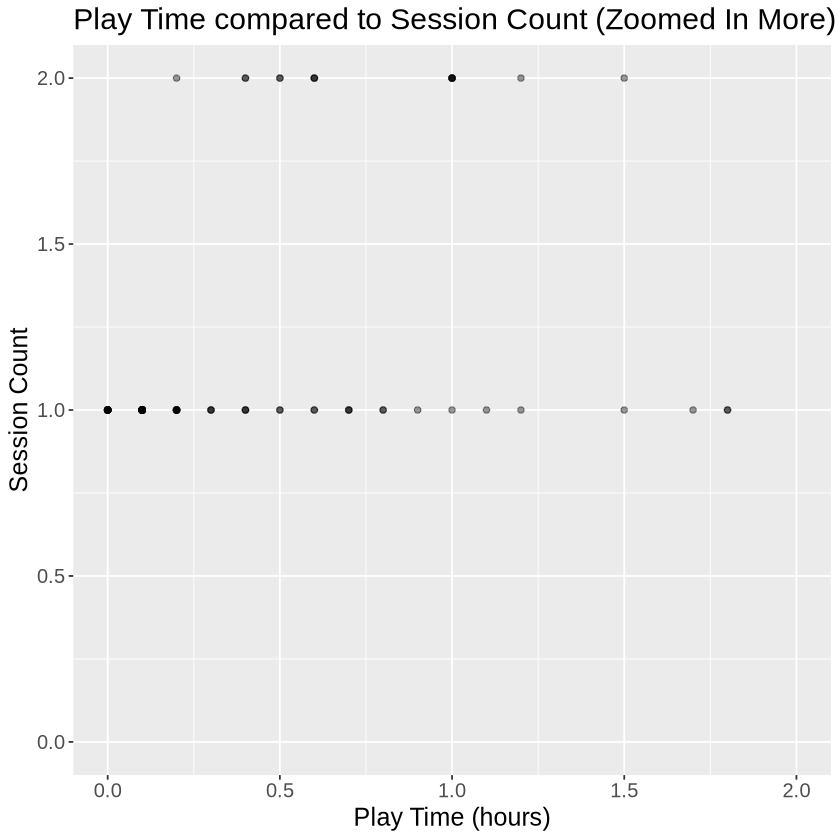

In [6]:
play_time_session_count_scatterplot <- play_time_session_count_merged |>
    ggplot(aes(x = played_hours, y = session_count)) +
   geom_point(alpha = 0.3) +
    geom_line(alpha = 0.3) +
    labs(x = "Play Time (hours)", y = "Session Count", title = "Play Time compared to Session Count")+
    theme(text = element_text(size = 15))

play_time_session_count_scatterplot



play_time_session_count_scatterplot_zoomed <- play_time_session_count_merged |>
    ggplot(aes(x = played_hours, y = session_count)) +
    geom_point(alpha = 0.4) +
    labs(x = "Play Time (hours)", y = "Session Count", title = "Play Time compared to Session Count (Zoomed In)")+
    scale_x_continuous(limits = c(0,5)) +
    scale_y_continuous(limits = c(0, 5)) +
    theme(text = element_text(size = 15))

play_time_session_count_scatterplot_zoomed

play_time_session_count_scatterplot_zoomed_2 <- play_time_session_count_merged |>
    ggplot(aes(x = played_hours, y = session_count)) +
    geom_point(alpha = 0.4) +
    labs(x = "Play Time (hours)", y = "Session Count", title = "Play Time compared to Session Count (Zoomed In More)")+
    scale_x_continuous(limits = c(0,2)) +
    scale_y_continuous(limits = c(0, 2)) +
    theme(text = element_text(size = 15))


play_time_session_count_scatterplot_zoomed_2

From the three scatterplots above we can see there is a moderate positive correlation between play time and the count of sessions played. This is not surprising, but we can also see that most of our data points have very few hours on the server. This leaves us with few data points to base our predictions off of later, we can see that

In [7]:
count(play_time_session_count_merged)
play_time_session_count_merged |> filter(played_hours < 1) |> summarize(count_of_less_than_one_hour = n())
play_time_session_count_merged |> filter(session_count == 1) |> summarize(count_of_one_session = n())

n
<int>
125


count_of_less_than_one_hour
<int>
83


count_of_one_session
<int>
81


As we can see, 83/125 players have less than 1 hour of play time, and 81/125 players have just one session played. This provides greater context in the divide of player time commitments to the server. 

# **4: Methods and Plan**

I plan on using linear regression to display the relationship between play time and session count. Question 3 asks for a way to determine whether a player will continue playing given past participation, my argument is that play time can be used to predict the session count, and therefore indicate that a player will continue playing often. As we saw from the data above, many players do not have much play time, but those that do seem to commit many hours to the game. 

- Why is this method appropriate?
    - This method is appropriate because there seems to be a moderate linear relationship between the variables, making linear regression well suited for the task. 
- Which assumptions are required, if any, to apply the method selected?
    - We assume there is a linear relationship, which we have found to be the case. 
- What are the potential limitations or weaknesses of the method selected?
    - The lack of data points beyond 1 session, or 1 hour played may limit the accuracy of our regression, as most points have very small values. 
- How are you going to compare and select the model?
    - We will use RMSPE to view the average discrepancy between our model and the true values for our test set. This will provide us with an indication of how well our linear regression fits the data we have. 
- How are you going to process the data to apply the model?
    - Since we are using linear regression, we will not need to cross-validate or normalize the data. To create the training and testing split, however, we will use a 80/20 split as I would like a significant larger portion to train the data with, as we have so few values outside of the smaller values. We will split at the very beginning, ensuring to never mix the training and testing data. For the strata, we will use session_count as this is the variable we are attempting to predict. 



In [8]:
head(play_time_session_count_merged)

,hashedEmail,played_hours,session_count
,<chr>,<dbl>,<int>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1.5,2
2,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,0.4,1
3,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,0.1,1
4,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,5.6,13
5,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,1.0,2
6,11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,0.1,1


In [9]:
#Creating a regression model specification
lin_reg_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(session_count ~ played_hours, data = play_time_session_count_merged)
